#  Applied Machine Learning 

## Homework 5: Evaluation metrics


## Imports

In [83]:
import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
    cross_val_predict
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

<br><br>

## Exercise 1: Precision, recall, and f1 score by hand <a name="1"></a>
<hr>

Consider the problem of predicting whether a patient has a disease or not. Below are confusion matrices of two machine learning models: Model A and Model B. 

- Model A

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 2 | 8 |
| **Actual no disease**       | 0 | 100 |


- Model B

|    Actual/Predicted      | Predicted disease | Predicted no disease |
| :------------- | -----------------------: | -----------------------: |
| **Actual disease**       | 6 | 4 |
| **Actual no disease**       | 10 | 90 |

### 1.1 Positive vs. negative class 

**Your tasks:**

Precision, recall, and f1 score depend upon which class is considered "positive", that is the thing you wish to find. In the example above, which class is likely to be the "positive" class? Why? 

In [40]:
# --> For Model A
recall_A = 2/10 #Among all positive examples, how many did you identify?
precision_A = 2/2 #Among the positive examples you identified, how many were actually positive?
f1_score_A = (2*recall_A*precision_A)/(recall_A+precision_A)
print(f"For Model A :\n Recall : {recall_A} \n Precision : {precision_A} \n F1_score : {f1_score_A}\n")

# --> For Model B 
recall_B = 6/10
precision_B = 6/16
f1_score_B = (2*recall_B*precision_B)/(recall_B+precision_B)
print(f"For Model B :\n Recall : {recall_B} \n Precision : {precision_B} \n F1_score : {f1_score_B}")

For Model A :
 Recall : 0.2 
 Precision : 1.0 
 F1_score : 0.33333333333333337

For Model B :
 Recall : 0.6 
 Precision : 0.375 
 F1_score : 0.4615384615384615


<br><br>

### 1.2 Accuracy


**Your tasks:**

Calculate accuracies for Model A and Model B. 

We'll store all metrics associated with Model A and Model B in the `results_dict` below. 

In [41]:
results_dict = {"A": {}, "B": {}}

In [170]:
results_dict["A"]["accuracy"] = 102/110
results_dict["B"]["accuracy"] = 96/110



In [171]:
assert tests_hw5.ex1_2_1(
    results_dict["A"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [172]:
assert tests_hw5.ex1_2_2(
    results_dict["B"]["accuracy"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [174]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.927273,0.872727
precision,NaN,NaN
recall,NaN,NaN
f1,NaN,NaN


<br><br>

### 1.3 Which model would you pick? 

**Your tasks:**

Which model would you pick simply based on the accuracy metric? 

<br><br>

### 1.4 Precision, recall, f1-score
rubric={points:6}

**Your tasks:**

1. Calculate precision, recall, f1-score for Model A and Model B manually, without using `scikit-learn` tools. 


In [175]:
results_dict["A"]["precision"] =  2 / ( 2 + 0 )
results_dict["B"]["precision"] = 6 / ( 6 + 10 )
results_dict["A"]["recall"] = 2 / ( 2 + 8)
results_dict["B"]["recall"] = 6 / ( 6 + 4 )
results_dict["A"]["f1"] = 2 * ((results_dict["A"]["precision"] * results_dict["A"]["recall"])/(results_dict["A"]["precision"] + results_dict["A"]["recall"]))
results_dict["B"]["f1"] =  2 * ((results_dict["B"]["precision"] * results_dict["B"]["recall"])/(results_dict["B"]["precision"] + results_dict["B"]["recall"]))




In [176]:
assert tests_hw5.ex1_4_1(
    results_dict["A"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [177]:
assert tests_hw5.ex1_4_2(
    results_dict["B"]["precision"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [178]:
assert tests_hw5.ex1_4_3(
    results_dict["A"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [179]:
assert tests_hw5.ex1_4_4(
    results_dict["B"]["recall"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [180]:
assert tests_hw5.ex1_4_5(
    results_dict["A"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


In [181]:
assert tests_hw5.ex1_4_6(
    results_dict["B"]["f1"]
), "Your answer is incorrect, see traceback above."
print("Success")

Success


Show the dataframe with all results. 

In [182]:
pd.DataFrame(results_dict)

,A,B
accuracy,0.927273,0.872727
precision,1.000000,0.375000
recall,0.200000,0.600000
f1,0.333333,0.461538


<br><br>

### 1.5 Discussion

**Your tasks:**
1. Which metric is more informative in this problem? Why? 
2. Which model would you pick based on this information? 

<br><br>

### (Optional) 1.6 

**Your tasks:**

Provide 4 to 5 example classification datasets (with links) where accuracy metric would be misleading. Discuss which evaluation metric would be more appropriate for each dataset. You may consider datasets we have used in this course so far. You could also look up datasets on Kaggle. 

<br><br><br><br>

### Exercise 2: Classification evaluation metrics using `sklearn` <a name="2"></a>
<hr>

In general, when a dataset is imbalanced, accuracy does not provide the whole story. In class, we looked at credit card fraud dataset which is a classic example of an imbalanced dataset. 

Another example is customer churn datasets. [Customer churn](https://en.wikipedia.org/wiki/Customer_attrition) refers to the notion of customers leaving a subscription service like Netflix. In this exercise, we will try to predict customer churn in a dataset where most of the customers stay with the service and a small minority cancel their subscription. To start, please download the [Kaggle telecom customer churn dataset](https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). Once you have the data, you should be able to run the following code:

The starter code below reads the data CSV as a pandas dataframe and splits it into 70% train and 30% test. 

Note that `churn` column in the dataset is the target. "True" means the customer left the subscription (churned) and "False" means they stayed.

> Note that for this kind of problem a more appropriate technique is something called survival analysis and we'll be talking about it later in the course. For now, we'll just treat it as a binary classification problem. 

In [54]:
df = pd.read_csv("bigml_59c28831336c6604c800002a.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,...,77,17.40,256.6,101,11.55,5.7,4,1.54,1,False
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,...,76,12.10,91.2,86,4.10,10.9,5,2.94,2,False
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,...,103,7.62,220.0,91,9.90,15.6,4,4.21,2,False
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,...,105,13.86,282.5,100,12.71,10.0,3,2.70,1,False
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,...,95,22.23,241.6,104,10.87,11.4,9,3.08,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,WY,126,408,339-9798,yes,no,0,197.6,126,33.59,...,112,20.95,285.3,104,12.84,12.5,8,3.38,2,False
3089,WV,70,510,348-3777,no,yes,30,143.4,72,24.38,...,92,14.45,127.9,68,5.76,9.4,4,2.54,3,False
1766,NJ,125,415,406-6400,no,no,0,182.3,64,30.99,...,121,11.88,171.6,96,7.72,11.6,7,3.13,2,False
1122,NE,159,415,362-5111,no,no,0,189.1,105,32.15,...,147,20.92,242.0,106,10.89,10.4,5,2.81,1,True


<br><br>

### 2.1 Distribution of target values


**Your tasks:**

Examine the distribution of target values in the train split. Do you see class imbalance? If yes, do we need to deal with it? Why or why not? 

In [55]:
X_train , y_train = train_df.drop(columns=['churn']),train_df['churn']
X_test , y_test = train_df.drop(columns=['churn']),train_df['churn']

In [56]:
y_train.value_counts()

False    1984
True      349
Name: churn, dtype: int64

<br><br>

### (Optional) 2.2 EDA 

**Your tasks:**

Come up with **two** exploratory questions you would like to answer and explore those. Briefly discuss your results in 1-3 sentences.

You are welcome to use `pandas_profiling` (see Lecture 10) but you don't have to.

<br><br>

### 2.3 Column transformer 

The code below creates `X_train`, `y_train`, `X_test`, `y_test` for you. 
In preparation for building a classifier, set up a `ColumnTransformer` that performs whatever feature transformations you deem sensible. This can include dropping features if you think they are not helpful. Remember that by default `ColumnTransformer` will drop any columns that aren't accounted for when it's created.

In each case, briefly explain your rationale with 1-2 sentences. You do not need an explanation for every feature, but for every group of features that are being transformed the same way. For example, "I am doing transformation X to the following categorical features: `a`, `b`, `c` because of reason Y," etc.

In [57]:
X_train = train_df.drop(columns=["churn"])
X_test = test_df.drop(columns=["churn"])

y_train = train_df["churn"]
y_test = test_df["churn"]

In [58]:
X_train.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
1402,NE,70,415,421-8535,no,no,0,213.4,86,36.28,204.7,77,17.40,256.6,101,11.55,5.7,4,1.54,1
1855,WI,67,510,417-2265,no,no,0,109.1,134,18.55,142.3,76,12.10,91.2,86,4.10,10.9,5,2.94,2
633,NJ,122,415,327-9341,no,yes,34,146.4,104,24.89,89.7,103,7.62,220.0,91,9.90,15.6,4,4.21,2
1483,NV,107,510,419-9688,yes,no,0,234.1,91,39.80,163.1,105,13.86,282.5,100,12.71,10.0,3,2.70,1
2638,HI,105,510,364-8128,no,no,0,125.4,116,21.32,261.5,95,22.23,241.6,104,10.87,11.4,9,3.08,2


In [59]:
numeric_features = ['total day minutes', 'total day calls', 'total day charge','total eve minutes', 'total eve calls', 'total eve charge',
                    'total night minutes', 'total night calls', 'total night charge','total intl minutes','total intl calls',
                    'total intl charge','account length']
categorical_features = ['area code']
ordinal_features = []
binary_features = ['international plan','voice mail plan']
drop_features = ['phone number','state']
passthrough_features = ['number vmail messages']

In [60]:
preprocessor = make_column_transformer(
    (make_pipeline(StandardScaler()),numeric_features),
    (OneHotEncoder(drop='if_binary',dtype=int),binary_features),
    (OneHotEncoder(),categorical_features),
    ("passthrough", passthrough_features)
)

In [61]:
from sklearn import set_config
set_config(display='diagram')

In [62]:
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['total day minutes', 'total day calls',
                                  'total day charge', 'total eve minutes',
                                  'total eve calls', 'total eve charge',
                                  'total night minutes', 'total night calls',
                                  'total night charge', 'total intl minutes',
                                  'total intl calls', 'total intl charge',
                                  'account length']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['international plan', 'voice mail plan']),
                                ('onehotencoder-2', OneHotEncoder(),
                                 ['area code']),
                                ('passthrough', 'passthrough',
                                 ['number vmail messages'])])

<br><br>

### 2.4 Visualizing the transformed data 


Fit and transform your `ColumnTransformer` on your training set. Print the first 5 rows of the transformed data as a dataframe (not numpy array). See lecture 10 for code that can get you the new column names after transforming. 

In [63]:
preprocessed = preprocessor.fit_transform(X_train)
pd.DataFrame(preprocessed)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.618769,-0.721211,0.618927,0.069871,-1.156734,0.069926,1.088667,0.052115,1.089926,-1.645501,-0.200722,-1.644994,-0.767893,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.293778,1.655252,-1.293517,-1.167277,-1.207278,-1.166291,-2.162302,-0.720990,-2.164029,0.227019,0.198158,0.222249,-0.843585,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.609809,0.169963,-0.609654,-2.210130,0.157417,-2.211244,0.369287,-0.463288,0.369252,1.919489,-0.200722,1.916105,0.544113,0.0,1.0,0.0,1.0,0.0,34.0
3,0.998345,-0.473663,0.998611,-0.754894,0.258506,-0.755774,1.597736,0.000574,1.596582,-0.097071,-0.599603,-0.097850,0.165650,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.994886,0.764078,-0.994731,1.195994,-0.246937,1.196515,0.793839,0.206736,0.792921,0.407069,1.793679,0.408973,0.115188,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,0.329045,1.259175,0.328771,0.898602,0.612316,0.897957,1.652771,0.206736,1.653363,0.803179,1.394799,0.809096,0.645037,1.0,0.0,1.0,0.0,0.0,0.0
2329,-0.664820,-1.414346,-0.664665,-0.618094,-0.398570,-0.618157,-1.440956,-1.648715,-1.438987,-0.313131,-0.200722,-0.311249,-0.767893,0.0,1.0,0.0,0.0,1.0,30.0
2330,0.048489,-1.810423,0.048322,-1.216842,1.067214,-1.217606,-0.582024,-0.205587,-0.582913,0.479089,0.995918,0.475660,0.619806,0.0,0.0,0.0,1.0,0.0,0.0
2331,0.173180,0.219472,0.173445,0.890672,2.381365,0.890960,0.801701,0.309816,0.801656,0.046969,0.198158,0.048862,1.477656,0.0,0.0,0.0,1.0,0.0,0.0


In [64]:
preprocessor.named_transformers_

{'pipeline': Pipeline(steps=[('standardscaler', StandardScaler())]),
 'onehotencoder-1': OneHotEncoder(drop='if_binary', dtype=<class 'int'>),
 'onehotencoder-2': OneHotEncoder(),
 'passthrough': 'passthrough',
 'remainder': 'drop'}

In [65]:
# creating new columns list
columns_name = (numeric_features
    + preprocessor.named_transformers_["onehotencoder-1"].get_feature_names().tolist()
    + preprocessor.named_transformers_["onehotencoder-2"].get_feature_names().tolist()
    + passthrough_features
)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [66]:
columns_name

['total day minutes',
 'total day calls',
 'total day charge',
 'total eve minutes',
 'total eve calls',
 'total eve charge',
 'total night minutes',
 'total night calls',
 'total night charge',
 'total intl minutes',
 'total intl calls',
 'total intl charge',
 'account length',
 'x0_yes',
 'x1_yes',
 'x0_408',
 'x0_415',
 'x0_510',
 'number vmail messages']

In [67]:
pd.DataFrame(preprocessed, columns=columns_name).head(5)

,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,account length,x0_yes,x1_yes,x0_408,x0_415,x0_510,number vmail messages
0,0.618769,-0.721211,0.618927,0.069871,-1.156734,0.069926,1.088667,0.052115,1.089926,-1.645501,-0.200722,-1.644994,-0.767893,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.293778,1.655252,-1.293517,-1.167277,-1.207278,-1.166291,-2.162302,-0.720990,-2.164029,0.227019,0.198158,0.222249,-0.843585,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.609809,0.169963,-0.609654,-2.210130,0.157417,-2.211244,0.369287,-0.463288,0.369252,1.919489,-0.200722,1.916105,0.544113,0.0,1.0,0.0,1.0,0.0,34.0
3,0.998345,-0.473663,0.998611,-0.754894,0.258506,-0.755774,1.597736,0.000574,1.596582,-0.097071,-0.599603,-0.097850,0.165650,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.994886,0.764078,-0.994731,1.195994,-0.246937,1.196515,0.793839,0.206736,0.792921,0.407069,1.793679,0.408973,0.115188,0.0,0.0,0.0,0.0,1.0,0.0


<br><br>

### 2.5 area code feature

The original dataset had a feature called `area code`. Let's assume we encoded this feature with one-hot encoding.

1. The area codes were numbers to begin with. Why do we want to use one-hot encoding on this feature?
2. What were the possible values of `area code`? 
3. What new feature(s) were created to replace `area code`? 

In [68]:
df['area code'].unique()

array([415, 408, 510], dtype=int64)

<br><br>

### 2.6 Dummy classifier


**Your tasks:**

Create a `DummyClassifier`. Report the following scoring metrics via cross-validation: accuracy, precision, recall, f1-score. Briefly comment on your results, including any warnings the code produces (2 sentences max).

In [69]:
pipe_dummmy = DummyClassifier()
pipe_dummmy.fit(X_train,y_train)

pipe_dummmy.score(X_test,y_test)

0.866

In [70]:
data = {
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
}

In [71]:
data['accuracy'].append(accuracy_score(y_train,pipe_dummmy.predict(X_train)))
data['precision'].append(precision_score(y_train , pipe_dummmy.predict(X_train)))
data['recall'].append(recall_score(y_train,pipe_dummmy.predict(X_train)))
data['f1 score'].append(f1_score(y_train,pipe_dummmy.predict(X_train)))

new_df = pd.DataFrame(data)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
new_df

,accuracy,precision,recall,f1 score
0,0.850407,0.0,0.0,0.0


In [73]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]  # scoring can be a string, a list, or a dictionary

dummy_md = DummyClassifier()
scores = cross_validate(dummy_md , X_train , y_train , scoring = scoring)
pd.DataFrame(scores)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_precision
0,0.008052,0.016006,0.850107,0.0,0.0,0.0
1,0.003914,0.012603,0.850107,0.0,0.0,0.0
2,0.003951,0.012599,0.850107,0.0,0.0,0.0
3,0.000000,0.018758,0.851931,0.0,0.0,0.0
4,0.000000,0.016108,0.849785,0.0,0.0,0.0


<br><br>

### 2.7 Logistic regression

**Your tasks:**

1. Train and score a logistic regression classifier on the dataset. 
2. Report the same metrics as in the previous part.
3. Are you satisfied with the results? Use your `DummyClassifier` results as a reference point. Discuss in a few sentences. 

In [74]:
lr_pipe = make_pipeline(preprocessor , LogisticRegression())
lr_pipe.fit(X_train,y_train)
lr_pipe.predict(X_train)

all_score = classification_report(y_train , lr_pipe.predict(X_train) , target_names=['class 0','class 1'])
print(all_score)

              precision    recall  f1-score   support

     class 0       0.86      0.99      0.92      1984
     class 1       0.61      0.12      0.20       349

    accuracy                           0.86      2333
   macro avg       0.74      0.55      0.56      2333
weighted avg       0.83      0.86      0.81      2333



C:\Users\admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<br><br>

### 2.8 Logistic regression with `class_weight`
**Your tasks:**

1. Set the `class_weight` parameter of your logistic regression model to `'balanced'` and report the same metrics as in the previous part. 
2. Do you prefer this model to the one in the previous part? Discuss your results in a few sentences.

In [75]:
lr_pipe_w = make_pipeline(preprocessor , LogisticRegression(class_weight='balanced'))
lr_pipe_w.fit(X_train,y_train)
lr_pipe_w.predict(X_train) 

score_w = classification_report(y_train , lr_pipe_w.predict(X_train),target_names=['class 0','class 1'])
print(score_w)

              precision    recall  f1-score   support

     class 0       0.93      0.73      0.82      1984
     class 1       0.31      0.68      0.42       349

    accuracy                           0.72      2333
   macro avg       0.62      0.70      0.62      2333
weighted avg       0.83      0.72      0.76      2333



<br><br>

### 2.9 Hyperparameter optimization

Now let's tune the hyperparameters of our `LogisticRegression` using `GridSearchCV` to maximize cross-validation f1 score. 

**Your tasks:**

1. Jointly optimize `C` (choose some reasonable values) and `class_weight` (`None` vs. `'balanced'`) with `GridSearchCV` and `scoring="f1"`. 
2. What values of `C` and `class_weight` are chosen and what is the best cross-validation f1 score?

In [76]:
params = {
    'logisticregression__C':[0.01,0.1,1,10,100],
    'logisticregression__class_weight':['None','balanced']
}

In [77]:
pipe_lr = make_pipeline(preprocessor,LogisticRegression(max_iter=1000))

grid_cv = GridSearchCV(pipe_lr, params ,return_train_score=True , scoring='f1')
grid_cv.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['total '
                                                                          'day '
                                                                          'minutes',
                                                                          'total '
                                                                          'day '
                                                                          'calls',
                                                                          'total '
                                                                          'day '
                                                                          'charge',
                                                                          'total '
                                                                          'eve '
                                                                          'minutes',
                                                                          'total '
                                                                          'eve '
                                                                          'calls',
                                                                          'total '
                                                                          'eve '
                                                                          'charge',
                                                                          'total '
                                                                          'night '
                                                                          'minutes',
                                                                          'total '
                                                                          'night '
                                                                          'calls',
                                                                          'total '
                                                                          'night '
                                                                          'char...
                                                                         ['international '
                                                                          'plan',
                                                                          'voice '
                                                                          'mail '
                                                                          'plan']),
                                                                        ('onehotencoder-2',
                                                                         OneHotEncoder(),
                                                                         ['area '
                                                                          'code']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         ['number '
                                                                          'vmail '
                                                                          'messages'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.0

In [78]:
grid_cv.best_params_

{'logisticregression__C': 100, 'logisticregression__class_weight': 'balanced'}

In [79]:
grid_cv.best_score_

0.4107400759318297

<br><br>

### 2.10 Test results


**Your tasks**
1. Evaluate the best model on the test set. In particular show each of the following on the test set:  
    - Confusion matrix. 
    - Classification report. 
    - Precision-recall curve with average precision score.     
    - ROC curve with AUC. 
3. Comment on the results.    

> Note that we are not doing it here but in real life, you would also plot confusion matrix, precision-recall curve, and ROC curve on validation data to examine errors and to choose a threshold which works for your operating point. 

#### 1) Confusion Matrix

In [84]:
best_model = make_pipeline(preprocessor , LogisticRegression(max_iter=1000 , class_weight='balanced' , C=100))
best_model.fit(X_train , y_train)
confusion_matrix(y_train,cross_val_predict(best_model,X_train,y_train))

array([[1440,  544],
       [ 118,  231]], dtype=int64)

#### 2) Classification Report

In [86]:
scores = classification_report(y_train,best_model.predict(X_train), target_names=['class0','class1'])
print(scores)

              precision    recall  f1-score   support

      class0       0.93      0.73      0.82      1984
      class1       0.31      0.67      0.42       349

    accuracy                           0.72      2333
   macro avg       0.62      0.70      0.62      2333
weighted avg       0.83      0.72      0.76      2333



#### 3) Precision-recall curve with average precision score.

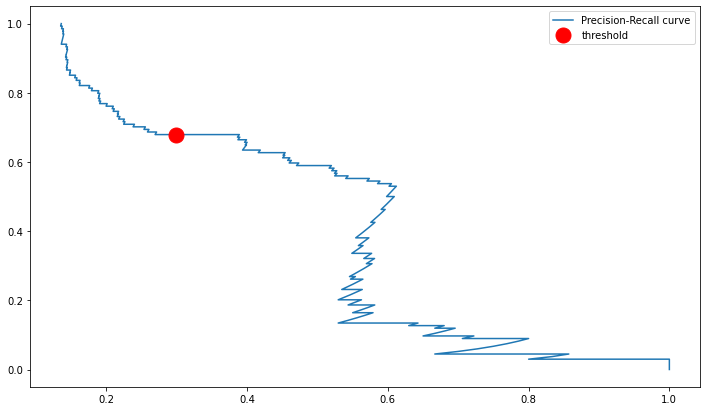

In [107]:
from sklearn.metrics import precision_recall_curve
plt.figure(figsize=(12,7))
precision,recall,threshold = precision_recall_curve(y_test,best_model.predict_proba(X_test)[:,1])

plt.plot(precision,recall ,label="Precision-Recall curve")

plt.plot(
    precision_score(y_test,best_model.predict(X_test)),
    recall_score(y_test,best_model.predict(X_test)),
    'or',
    markersize=15,
    label='threshold'

)
plt.legend(loc='best')

In [98]:
from sklearn.metrics import average_precision_score
print("Average Pricison score is : %0.3f"%average_precision_score(y_test ,best_model.predict_proba(X_test)[:,1]))

Average Pricison score is : 0.461


#### 4)ROU curve with AUC

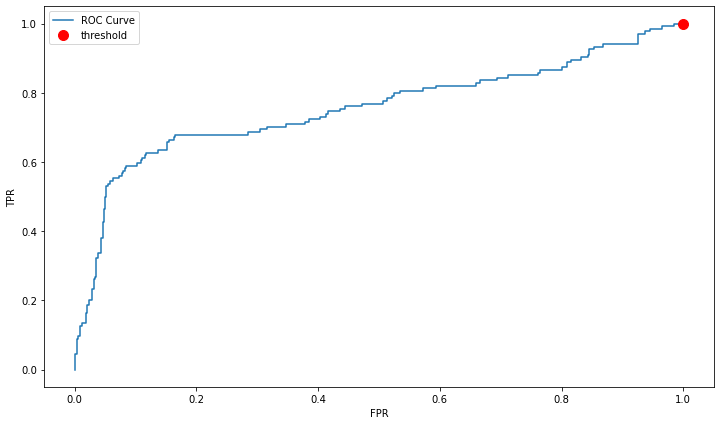

In [106]:
from sklearn.metrics import roc_curve,roc_auc_score
plt.figure(figsize=(12,7))
fpr , tpr ,threshold = roc_curve(y_test,best_model.predict_proba(X_test)[:,1])
def_thr = np.argmin(np.abs(threshold))

plt.plot(fpr,tpr,label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")

plt.plot(fpr[def_thr],tpr[def_thr],'or',markersize=10,label="threshold")

plt.legend(loc="best")

In [109]:
fpr[def_thr]

1.0

In [110]:
def_thr

163


### Exercise 3: Regression metrics


For this exercise, we'll use [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) from `sklearn datasets`. The code below loads the dataset.  

In [111]:
from sklearn.datasets import fetch_california_housing

housing_df = fetch_california_housing(as_frame=True).frame

In [112]:
housing_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


### 3.1: Data spitting and exploration 


**Your tasks:**

1. Split the data into train (80%) and test (20%) splits. 
2. Explore the train split. Do you need to apply any transformations on the data? If yes, create a preprocessor with the appropriate transformations. 
3. Separate `X` and `y` in train and test splits. 

In [116]:
train_df ,test_df = train_test_split(housing_df,test_size=0.20,random_state=42)

In [119]:
train_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965
...,...,...,...,...,...,...,...,...,...
11284,6.3700,35.0,6.129032,0.926267,658.0,3.032258,33.78,-117.96,2.292
11964,3.0500,33.0,6.868597,1.269488,1753.0,3.904232,34.02,-117.43,0.978
5390,2.9344,36.0,3.986717,1.079696,1756.0,3.332068,34.03,-118.38,2.221
860,5.7192,15.0,6.395349,1.067979,1777.0,3.178891,37.58,-121.96,2.835


In [123]:
#Scalling
colums = ['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']
ct = make_column_transformer(
    (StandardScaler(),colums)
)

In [124]:
X_train ,y_train = train_df.drop(columns=['MedHouseVal']) , train_df['MedHouseVal']
X_test ,y_test = test_df.drop(columns=['MedHouseVal']) , test_df['MedHouseVal']

<br><br>

### 3.2 Baseline: DummyRegressor 


**Your tasks:**
1. Carry out cross-validation using `DummyRegressor` with default scoring. 
2. What metric is used for scoring by default? 

In [130]:
model_dummy = make_pipeline(ct, DummyRegressor())
scoring = cross_val_score(model_dummy,X_train,y_train,cv=5)
pd.DataFrame(scoring)

,0
0,-0.000372
1,-0.000017
2,-0.000002
3,-0.001130
4,-0.000066


### 3.3 Different regressors


In this exercise, we are going to use [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) model which we haven't looked into yet. At this point you should feel comfortable using models with our usual ML workflow even if you don't know the details. We'll talk about `RandomForestRegressor` later in the course.  

The code below defines a custom scorer called `mape_scorer` and creates dictionaries for different regressors (`models`) and different scoring metrics (`score_types_reg`). 

**Your tasks:**

1. Using the `models` and the evaluation metrics `score_types_reg` in the code below, carry out cross-validation with each model, by passing the evaluation metrics to `scoring` argument of `cross_validate`. Use a pipeline with the model as an estimator if you are applying any transformations. 
2. Show results as a dataframe. 
3. Interpret the results. How do the models compare to the baseline? Which model seems to be performing well with different metrics? 


In [131]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=False)

models = {
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
}

score_types_reg = {
    "neg_mean_squared_error": "neg_mean_squared_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "r2": "r2",
    "mape_scorer": mape_scorer,
}

In [132]:
result_dict = {}
for m in models:
    model=make_pipeline(ct,models[m])
    res = cross_validate(model,X_train,y_train,cv=5,scoring=score_types_reg)
    for i in res:
        res[i] = res[i].mean()
    result_dict[m]=res

In [133]:
pd.DataFrame(result_dict)

,Ridge,Random Forest
fit_time,0.044275,30.934477
score_time,0.016718,0.353210
test_neg_mean_squared_error,-0.519266,-0.261996
test_neg_root_mean_squared_error,-0.720528,-0.511826
test_neg_mean_absolute_error,-0.529057,-0.334895
test_r2,0.611484,0.803863
test_mape_scorer,-31.528057,-18.746011


<br><br>

### (Optional) 3.4 Hyperparameter optimization 

**Your tasks:**
1. Carry out hyperparameter optimization using `RandomizedSearchCV` and `Ridge` with the following `param_dist`. The `alpha` hyperparameter of `Ridge` controls the fundamental tradeoff. Choose the metric of your choice for hyperparameter optimization. 
2. Are you getting better scores compared to the default values?

In [147]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": loguniform(1e-3, 1e3)}

In [140]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score

In [141]:
from scipy.stats import loguniform

param_dist = {"ridge__alpha": [1e-4, 1e-3,1e-2, 1, 5, 10, 20] }

model_opt = make_pipeline(ct,Ridge())

score_types_reg = {
    "neg_mean_squared_error": make_scorer(mean_squared_error,greater_is_better=False),
    "neg_mean_absolute_error": make_scorer(mean_absolute_error,greater_is_better=False),
    "r2": make_scorer(r2_score,greater_is_better=False),
    "mape_scorer": mape_scorer,
}

score_types_reg1 = [
    'neg_mean_absolute_error',
    'neg_mean_absolute_percentage_error',
    'neg_root_mean_squared_error',
    'neg_mean_squared_error',
    'r2'
]

vals = RandomizedSearchCV(model_opt,param_dist,n_jobs=-1,scoring=score_types_reg1,random_state=123,refit=False)

In [143]:
vals.fit(X_train,y_train)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['MedInc',
                                                                                'HouseAge',
                                                                                'AveRooms',
                                                                                'AveBedrms',
                                                                                'Population',
                                                                                'AveOccup',
                                                                                'Latitude',
                                                                                'Longitude'])])),
                                             ('ridge', Ridge())]),
                   n_jobs=-1,
                   param_distributions={'ridge__alpha': [0.0001, 0.001, 0.01, 1,
                                                         5, 10, 20]},
                   random_state=123, refit=False,
                   scoring=['neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error',
                            'neg_root_mean_squared_error',
                            'neg_mean_squared_error', 'r2'])

In [146]:
rcv_results = pd.DataFrame(vals.cv_results_)
rcv_results.T

,0,1,2,3,4,5,6
mean_fit_time,0.102339,0.082489,0.04875,0.04592,0.046903,0.052215,0.04855
std_fit_time,0.010511,0.020159,0.00363,0.001953,0.003449,0.006934,0.003613
mean_score_time,0.025543,0.021405,0.0252,0.029349,0.022941,0.020788,0.016935
std_score_time,0.011422,0.002644,0.004676,0.011478,0.003223,0.003795,0.004311
param_ridge__alpha,0.0001,0.001,0.01,1,5,10,20
params,{'ridge__alpha': 0.0001},{'ridge__alpha': 0.001},{'ridge__alpha': 0.01},{'ridge__alpha': 1},{'ridge__alpha': 5},{'ridge__alpha': 10},{'ridge__alpha': 20}
split0_test_neg_mean_absolute_error,-0.531131,-0.531131,-0.531131,-0.531131,-0.531137,-0.531148,-0.531178
split1_test_neg_mean_absolute_error,-0.526751,-0.526751,-0.526751,-0.526751,-0.526753,-0.526759,-0.526778
split2_test_neg_mean_absolute_error,-0.524198,-0.524198,-0.524198,-0.524198,-0.524197,-0.5242,-0.524225
split3_test_neg_mean_absolute_error,-0.524794,-0.524794,-0.524794,-0.524782,-0.524737,-0.524682,-0.524593


<br><br>

### 3.5 Test results

**Your tasks:**

1. Try the best model on the test set.
2. Briefly comment on the results. (1 to 2 sentences) 

In [149]:
final_best_model = make_pipeline(ct,Ridge(alpha=20.740242))
final_best_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude',
                                                   'Longitude'])])),
                ('ridge', Ridge(alpha=20.740242))])

In [150]:
pd.DataFrame(cross_validate(final_best_model,X_train,y_train,return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.030815,0.015077,0.619962,0.610412
1,0.033377,0.014368,0.612912,0.612360
2,0.024117,0.009722,0.613218,0.612201
3,0.023591,0.009969,0.610658,0.612496
4,0.030347,0.009723,0.600418,0.615554


In [151]:
final_best_model.score(X_test,y_test)

0.5763325576283214

<br><br>

### 3.6 Model interpretation  


Ridge is a linear model and it learns coefficients associated with each feature during `fit()`. 

**Your tasks:**

1. Visualize coefficients learned by the `Ridge` model above as a pandas dataframe with two columns: features and coefficients. If you attempted 3.4, use the `Ridge` model with best hyperparameters. Otherwise use the `Ridge` model with default hyperparameters. 
2. Increasing which feature values would result in higher housing price? 

In [152]:
train_df.columns

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')

<AxesSubplot:>

<Figure size 1080x648 with 0 Axes>

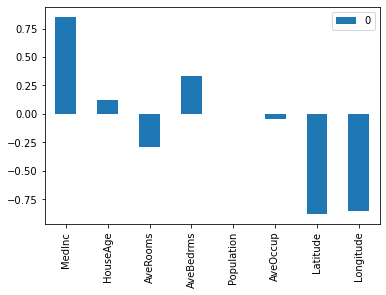

In [162]:
plt.figure(figsize=(15,9))
pd.DataFrame(final_best_model.named_steps['ridge'].coef_,index=X_train.columns.tolist()).plot(kind='bar')

In [163]:
final_best_model.named_steps['ridge'].coef_

array([ 0.85318621,  0.12412246, -0.29026499,  0.33406821, -0.00179041,
       -0.04090628, -0.88144544, -0.85415538])

<br><br>